## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
564
+------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|               res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|13523.756321247927| -3777.054209973213|1835.554464501612|   3448.2|SSSBBBBB|    39.8|-105.7833|       SNWD| 0.0991371145795564|0.030265373386074053|0.015850354815698856|0.7631

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'

sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00050674|    39.8|-105.7833|   3448.2|13523.756321247927|
|USC00051660| 39.3672|-106.1897|   3442.4|12513.401764373972|
|USC00050674|    39.8|-105.7833|   3448.2|13395.417710888607|
|USC00051660| 39.3672|-106.1897|   3442.4|12001.671361026172|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head()

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
19,US1COEG0008,39.7332,-106.6806,2201.9,1,-693.425896
1,US1COGL0013,39.7961,-105.4192,2734.7,1,-1327.798881
4,US1COJF0024,39.5346,-105.2273,2364.9,2,-522.649533
10,US1COJF0040,39.7611,-105.2297,1761.7,1,-1220.750228
7,US1COJF0051,39.5561,-105.3114,2436.9,1,-260.774137


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0040ff'

## Map

In [11]:
min_lat = min(pdf['latitude'])
max_lat = max(pdf['latitude'])
min_long = min(pdf['longitude'])
max_long = max(pdf['longitude'])

In [12]:
min_lat,max_lat,min_long,max_long = box = (min_lat, max_lat,min_long, max_long)


In [13]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F90', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

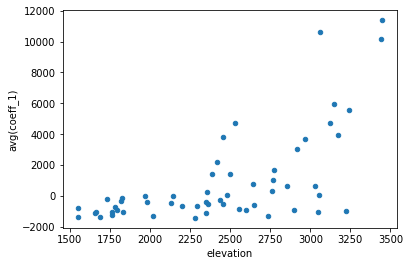

In [13]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [14]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']